# pytorch for generating music reviews

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print('cuda.is_available:', torch.cuda.is_available())
print(f'available: {torch.cuda.device_count()}; current: {torch.cuda.current_device()}')
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
print('pytorch', torch.__version__)

cuda.is_available: True
available: 1; current: 0
cuda:0
pytorch 0.4.0


## Data

In [2]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'datasets')

BLOG_CONTENT_FILE = os.path.join(DATA_DIR, f'blog_content_en_sample.json')
BLOG_CONTENT_DF = pd.read_json(BLOG_CONTENT_FILE)
print(f'total word_count: {sum(BLOG_CONTENT_DF.word_count)}; char_count: {sum([len(w) for w in BLOG_CONTENT_DF.content])}')
BLOG_CONTENT_DF.head().content

total word_count: 241026; char_count: 1417998


0    New Music\n\nMt. Joy reached out to us with th...
1    Folk rockers Mt. Joy have debuted their new so...
2    You know we're digging Mt. Joy.\n\nTheir new s...
3    Nothing against the profession, but the U.S. h...
4    Connecticut duo **Opia** have released a guita...
Name: content, dtype: object

In [3]:
TRAIN_DF, TEST_DF = train_test_split(BLOG_CONTENT_DF, test_size=0.2, random_state=42)
TRAIN_TEXT, TEST_TEXT = TRAIN_DF.content, TEST_DF.content
print(f'train_text word_count: {sum([len(t) for t in TRAIN_TEXT])}; test_text word_count: {sum([len(t) for t in TEST_TEXT])}')

train_text word_count: 1113633; test_text word_count: 304365


## Helpers

In [4]:
BPTT = 4 # like the 'n' in n-gram, or order
BS = 512 # batch size
EPOCHS = 5
N_FAC = 42 # number of latent factors
N_HIDDEN = 128

In [5]:
def pad_start(bptt):
    return '\0' * bptt

In [6]:
def create_inputs(texts_arr, print_info=False):
    # shuffle inputs
    texts_arr = texts_arr.sample(frac=1).reset_index(drop=True)
    
    # pad each new text with leading '\0' so that we learn how to start
    # also, lowercase
    texts = ''.join([pad_start(BPTT) + text.lower() for text in texts_arr])

    chars = sorted(list(set(texts)))
    vocab_size = len(chars)
    if print_info:
        print('vocab_size:', vocab_size)
        print(chars)
        print()

    char_to_idx = {c: i for i, c in enumerate(chars)}
    idx_to_char = {i: c for i, c in enumerate(chars)}

    idx = [char_to_idx[text] for text in texts]    
    return idx, vocab_size, char_to_idx, idx_to_char

_, VOCAB_SIZE, _, _ = create_inputs(TRAIN_TEXT, True)

vocab_size: 70
['\x00', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']



In [7]:
import math
import time

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s:.0f}s'

In [8]:
# https://github.com/fastai/fastai/blob/master/fastai/nlp.py
# TODO: generator
def batchify(data, bs):
    if bs == 1:
        return torch.tensor([[data[i+o] for i in range(len(data)-BPTT-1)] for o in range(BPTT+1)], dtype=torch.long, device=DEVICE)
    else:
        num = data.size(0) // bs
        data = data[:num*bs]
        # invalid argument 2: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Call .contiguous() before .view().
        return data.view(bs, -1).t().contiguous()
    

def get_batch(data, i, seq_len):
    seq_len = min(seq_len, len(data) - 1 - i)
    return data[i:i+seq_len].to(DEVICE), data[i+1:i+1+seq_len].view(-1).to(DEVICE)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
    
def plot_loss(losses):
    %matplotlib inline
    plt.figure()
    plt.plot(all_losses)

In [10]:
def batch_train(model, batches, optimizer, criterion=nn.CrossEntropyLoss(), bptt=BPTT):
    model.zero_grad()
    loss = 0
    
    for i in range(batches.size(0) - bptt):
        xs, ys = get_batch(batches, i, bptt)
        output = model(xs)
        loss += criterion(output, ys)
        
    loss.backward()
    if optimizer:
        optimizer.step()
    
    return loss.item() / (batches.size(0) - bptt)

def batchless_train(model, batches, optimizer, start, criterion=nn.CrossEntropyLoss(), bptt=BPTT):
    xs = np.stack(batches[:-1], axis=1) # history
    ys = np.stack(batches[-1:][0]) # target

    for i in range(xs.shape[0]):
        model.zero_grad()
        output = model(torch.tensor(xs[i], dtype=torch.long, device=DEVICE))

        loss = criterion(output, torch.tensor([ys[i]], dtype=torch.long, device=DEVICE))
        
        loss.backward()
        if optimizer:
            optimizer.step()
        
        print_every = 5000
        if i % print_every == 0:
            print(f'{time_since(start)} ({i} {i / xs.shape[0] * 100:.2f}%) {loss:.4f}')
    
    return loss.item()

In [11]:
def sample(model, char_to_idx, idx_to_char, seed=pad_start(BPTT), max_length=20, bptt=BPTT, sample=True):
    with torch.no_grad(): # no need to track history in sampling
        output_idx = [char_to_idx[c] for c in seed[-bptt:]]

        for i in range(max_length):
            h_idxs = torch.tensor(output_idx[-bptt:], dtype=torch.long, device=DEVICE).view(-1, 1)
            output = model(h_idxs.transpose(0,1))
            if sample:
                # sample from distribution
                idx = torch.multinomial(output[-1].exp(), 1).item()
            else:
                # get most probable
                topi = output.topk(1)[1]
                idx = topi[0][0]
            if idx == 0:
                break
            else:
                output_idx.append(idx)

        sample_text = ''.join([idx_to_char[i] for i in output_idx])
        print(sample_text)
        #print(output_idx)

In [12]:
def train_loop(model, optimizer, text, batch_size=BS, seed='the ', max_sample_length=100, epochs=EPOCHS, print_every=10, plot_every=10):
    # keep track of losses for plotting
    all_losses = []
    loss_avg = 0

    start = time.time()

    for epoch in range(epochs):
        idx, VOCAB_SIZE, char_to_idx, idx_to_char = create_inputs(text)
        batches = batchify(torch.tensor(np.stack(idx), device=DEVICE), batch_size)
        if batch_size == 1:
            loss = batchless_train(model, batches, optimizer, start)
        else:
            loss = batch_train(model, batches, optimizer)

        loss_avg += loss

        if epoch % print_every == 0:
            print(f'{time_since(start)} ({epoch} {epoch / EPOCHS * 100:.2f}%) {loss:.4f}')
            print(f'Epoch {epoch} sample:')
            sample(model, char_to_idx, idx_to_char, seed=seed, max_length=max_sample_length)

        if epoch % plot_every == 0:
            all_losses.append(loss_avg / plot_every)
            loss_avg = 0

    end = time.time()
    print(f'Training time: {end-start:.2f}s')
    return all_losses

##  with n-grams

Another [n-gram music reviews](https://github.com/iconix/openai/blob/master/nbs/n-gram%20music%20reviews.ipynb) model, implemented this time in PyTorch.

**TODO**: differences in models

Guiding PyTorch tutorial: [An Example: N-Gram Language Modeling](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#an-example-n-gram-language-modeling)

In [10]:
# TODO: draw computational graph
class NGramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, n_fac, bptt):
        super(NGramLanguageModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, n_fac)
        self.linear1 = nn.Linear(bptt * n_fac, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        inputs = self.embedding(inputs).view((1, -1))
        out = F.relu(self.linear1(inputs))
        out = self.linear2(out)
        return out

0m 52s (0 0.00%) 4.2055
0m 57s (5000 0.45%) 2.4855
1m 2s (10000 0.89%) 3.5794
1m 7s (15000 1.34%) 3.2981
1m 12s (20000 1.79%) 3.2731
1m 17s (25000 2.23%) 4.1420
1m 22s (30000 2.68%) 1.7753
1m 27s (35000 3.13%) 1.7436
1m 33s (40000 3.58%) 4.0775
1m 38s (45000 4.02%) 6.9683
1m 43s (50000 4.47%) 2.9456
1m 48s (55000 4.92%) 1.8573
1m 53s (60000 5.36%) 2.7968
1m 58s (65000 5.81%) 2.6559
2m 4s (70000 6.26%) 3.1677
2m 9s (75000 6.70%) 4.3779
2m 14s (80000 7.15%) 2.8005
2m 19s (85000 7.60%) 3.7645
2m 24s (90000 8.05%) 3.6518
2m 29s (95000 8.49%) 2.6440
2m 34s (100000 8.94%) 2.6335
2m 40s (105000 9.39%) 4.1102
2m 45s (110000 9.83%) 2.9233
2m 50s (115000 10.28%) 3.1986
2m 55s (120000 10.73%) 2.8402
3m 0s (125000 11.17%) 3.2028
3m 5s (130000 11.62%) 5.2876
3m 10s (135000 12.07%) 2.5888
3m 16s (140000 12.51%) 1.9415
3m 21s (145000 12.96%) 4.9262
3m 26s (150000 13.41%) 4.6647
3m 31s (155000 13.86%) 2.0333
3m 36s (160000 14.30%) 2.8166
3m 41s (165000 14.75%) 4.2258
3m 46s (170000 15.20%) 1.9813
3m 5

23m 40s (215000 19.22%) 3.2580
23m 44s (220000 19.67%) 3.2701
23m 49s (225000 20.11%) 4.6577
23m 54s (230000 20.56%) 6.0120
23m 59s (235000 21.01%) 1.8149
24m 3s (240000 21.45%) 2.8257
24m 8s (245000 21.90%) 2.8287
24m 13s (250000 22.35%) 4.2488
24m 18s (255000 22.79%) 1.8541
24m 22s (260000 23.24%) 3.4551
24m 27s (265000 23.69%) 3.4126
24m 32s (270000 24.14%) 3.6861
24m 37s (275000 24.58%) 4.2740
24m 42s (280000 25.03%) 1.8959
24m 47s (285000 25.48%) 2.8087
24m 52s (290000 25.92%) 3.6293
24m 56s (295000 26.37%) 3.0372
25m 1s (300000 26.82%) 3.7406
25m 6s (305000 27.26%) 2.0533
25m 11s (310000 27.71%) 3.6723
25m 16s (315000 28.16%) 7.0528
25m 21s (320000 28.60%) 3.3752
25m 25s (325000 29.05%) 2.8438
25m 30s (330000 29.50%) 1.8876
25m 35s (335000 29.95%) 3.2982
25m 40s (340000 30.39%) 1.8672
25m 45s (345000 30.84%) 3.2888
25m 49s (350000 31.29%) 4.0120
25m 54s (355000 31.73%) 3.8430
25m 59s (360000 32.18%) 2.9034
26m 4s (365000 32.63%) 1.8356
26m 8s (370000 33.07%) 2.4656
26m 13s (37500

45m 59s (430000 38.44%) 2.8654
46m 4s (435000 38.88%) 2.6688
46m 9s (440000 39.33%) 3.4721
46m 14s (445000 39.78%) 2.9189
46m 18s (450000 40.23%) 1.8991
46m 23s (455000 40.67%) 3.5482
46m 28s (460000 41.12%) 2.7731
46m 32s (465000 41.57%) 2.9471
46m 37s (470000 42.01%) 2.7771
46m 42s (475000 42.46%) 2.8979
46m 47s (480000 42.91%) 2.4270
46m 51s (485000 43.35%) 2.9284
46m 56s (490000 43.80%) 3.7662
47m 1s (495000 44.25%) 2.8110
47m 5s (500000 44.69%) 1.9503
47m 10s (505000 45.14%) 3.4050
47m 15s (510000 45.59%) 2.6609
47m 19s (515000 46.04%) 2.4349
47m 24s (520000 46.48%) 3.3408
47m 29s (525000 46.93%) 2.9526
47m 33s (530000 47.38%) 2.9179
47m 38s (535000 47.82%) 2.4582
47m 43s (540000 48.27%) 1.8160
47m 48s (545000 48.72%) 3.6936
47m 52s (550000 49.16%) 1.8031
47m 57s (555000 49.61%) 1.9246
48m 2s (560000 50.06%) 4.2367
48m 6s (565000 50.51%) 2.7788
48m 11s (570000 50.95%) 2.4858
48m 16s (575000 51.40%) 2.4539
48m 21s (580000 51.85%) 3.7489
48m 25s (585000 52.29%) 3.0301
48m 30s (59000

68m 3s (645000 57.66%) 2.7986
68m 8s (650000 58.10%) 4.0076
68m 13s (655000 58.55%) 3.4670
68m 17s (660000 59.00%) 2.6949
68m 22s (665000 59.44%) 3.3139
68m 27s (670000 59.89%) 3.0102
68m 32s (675000 60.34%) 3.9750
68m 37s (680000 60.79%) 4.1405
68m 42s (685000 61.23%) 2.4227
68m 47s (690000 61.68%) 3.5164
68m 52s (695000 62.13%) 3.8773
68m 56s (700000 62.57%) 3.3819
69m 1s (705000 63.02%) 2.4550
69m 6s (710000 63.47%) 3.2999
69m 11s (715000 63.91%) 4.1910
69m 16s (720000 64.36%) 2.3727
69m 21s (725000 64.81%) 3.2793
69m 26s (730000 65.25%) 3.5981
69m 31s (735000 65.70%) 2.6297
69m 36s (740000 66.15%) 3.8572
69m 41s (745000 66.60%) 5.1198
69m 46s (750000 67.04%) 2.6364
69m 51s (755000 67.49%) 2.7988
69m 56s (760000 67.94%) 6.8891
70m 1s (765000 68.38%) 2.5425
70m 6s (770000 68.83%) 1.8381
70m 11s (775000 69.28%) 3.1047
70m 16s (780000 69.72%) 3.3231
70m 21s (785000 70.17%) 7.1029
70m 27s (790000 70.62%) 2.3399
70m 32s (795000 71.06%) 3.7170
70m 37s (800000 71.51%) 2.9900
70m 42s (80500

90m 21s (860000 76.88%) 2.4361
90m 25s (865000 77.32%) 2.0536
90m 30s (870000 77.77%) 4.0350
90m 35s (875000 78.22%) 2.7297
90m 40s (880000 78.66%) 3.7336
90m 45s (885000 79.11%) 2.6828
90m 49s (890000 79.56%) 2.9295
90m 54s (895000 80.00%) 2.8365
90m 59s (900000 80.45%) 5.4987
91m 3s (905000 80.90%) 3.7212
91m 8s (910000 81.34%) 2.9688
91m 13s (915000 81.79%) 2.9356
91m 18s (920000 82.24%) 1.8424
91m 22s (925000 82.69%) 1.9180
91m 27s (930000 83.13%) 4.2457
91m 32s (935000 83.58%) 19.7108
91m 37s (940000 84.03%) 2.8249
91m 42s (945000 84.47%) 3.6646
91m 46s (950000 84.92%) 2.2650
91m 51s (955000 85.37%) 2.7461
91m 56s (960000 85.81%) 3.8593
92m 1s (965000 86.26%) 3.6155
92m 6s (970000 86.71%) 5.1761
92m 10s (975000 87.16%) 2.3261
92m 15s (980000 87.60%) 2.9361
92m 20s (985000 88.05%) 2.4775
92m 25s (990000 88.50%) 3.2864
92m 29s (995000 88.94%) 1.8685
92m 34s (1000000 89.39%) 1.8164
92m 39s (1005000 89.84%) 3.8503
92m 44s (1010000 90.28%) 2.6330
92m 48s (1015000 90.73%) 2.7505
92m 53s

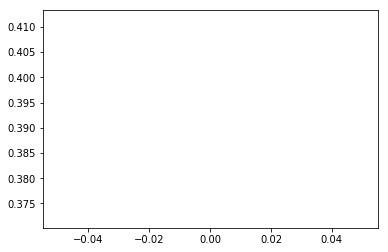

In [14]:
ngram = NGramLanguageModel(VOCAB_SIZE, N_HIDDEN, N_FAC, BPTT).to(DEVICE)
optimizer = optim.Adam(ngram.parameters(), lr=0.005)
all_losses = train_loop(ngram, optimizer, TRAIN_TEXT, batch_size=1)
plot_loss(all_losses)

In [46]:
sample(ngram, char_to_idx, idx_to_char, seed='the ', max_length=100)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCStorage.c:36

**Observations**:
- Training, even on a sample 2K reviews, is _slow_ (5 epochs in 67m 18s). Could we speed up with:
    - Batching
    - Adaptive learning rates (although this may make it train better but not necessarily faster)
    - Using PyTorch implementations of RNNs/LSTMs

## with rnn

In [15]:
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_fac, bptt, batch_size=BS):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embeddings = nn.Embedding(vocab_size, n_fac)
        self.i2h = nn.Linear(bptt * n_fac + hidden_size, hidden_size)
        self.i2o = nn.Linear(bptt * n_fac + hidden_size, vocab_size)
        self.o2o = nn.Linear(hidden_size + vocab_size, vocab_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.init_hidden(batch_size)
        
    # NOTE: this example only works as-is in PyTorch 0.4+
    # https://stackoverflow.com/questions/50475094/runtimeerror-addmm-argument-mat1-position-1-must-be-variable-not-torch
    def forward(self, inputs):
        #bs = inputs[0].size(0)
        # dynamic batch sizing
        #if self.batch_size != bs: self.init_hidden(bs)
        
        embeds = self.embeddings(inputs).view((1, -1))
        combined_i = torch.cat((embeds, self.hidden), 1)
        hidden = self.i2h(combined_i)
        # detach from history of the last run
        self.hidden = hidden.detach()
        output = self.i2o(combined_i)
        combined_o = torch.cat((self.hidden, output), 1)
        output = self.o2o(combined_o)
        output = self.dropout(output)
        output = self.softmax(output)
        return output
    
    def init_hidden(self, bs):
        # 1 RNN layer
        self.batch_size = bs
        self.hidden = torch.zeros(1, self.hidden_size).to(DEVICE)

0m 49s (0 0.00%) 4.2568
0m 56s (5000 0.45%) 3.2398
1m 2s (10000 0.89%) 1.4860
1m 9s (15000 1.34%) 1.4779
1m 15s (20000 1.79%) 1.5848
1m 21s (25000 2.23%) 2.4026
1m 28s (30000 2.68%) 1.8211
1m 34s (35000 3.13%) 5.7256
1m 40s (40000 3.58%) 3.7264
1m 47s (45000 4.02%) 4.1468
1m 53s (50000 4.47%) 1.0044
1m 59s (55000 4.92%) 2.2456
2m 6s (60000 5.36%) 6.0922
2m 13s (65000 5.81%) 3.1603
2m 19s (70000 6.26%) 4.4318
2m 25s (75000 6.70%) 0.9746
2m 32s (80000 7.15%) 4.1533
2m 38s (85000 7.60%) 2.1196
2m 45s (90000 8.05%) 5.3575
2m 51s (95000 8.49%) 1.7710
2m 57s (100000 8.94%) 1.6641
3m 4s (105000 9.39%) 2.9498
3m 11s (110000 9.83%) 1.2493
3m 17s (115000 10.28%) 2.1676
3m 24s (120000 10.73%) 0.7876
3m 30s (125000 11.17%) 3.3074
3m 37s (130000 11.62%) 1.9617
3m 44s (135000 12.07%) 1.3972
3m 50s (140000 12.51%) 3.9954
3m 56s (145000 12.96%) 4.0392
4m 2s (150000 13.41%) 1.9690
4m 9s (155000 13.86%) 2.5584
4m 15s (160000 14.30%) 4.0800
4m 22s (165000 14.75%) 3.6406
4m 28s (170000 15.20%) 4.7540
4m 3

30m 6s (210000 18.77%) 1.1395
30m 12s (215000 19.22%) 0.9454
30m 19s (220000 19.67%) 1.7563
30m 25s (225000 20.11%) 6.3011
30m 31s (230000 20.56%) 0.2217
30m 38s (235000 21.01%) 5.2502
30m 44s (240000 21.45%) 5.3388
30m 51s (245000 21.90%) 0.6641
30m 57s (250000 22.35%) 1.2559
31m 4s (255000 22.79%) 4.1674
31m 10s (260000 23.24%) 0.0000
31m 17s (265000 23.69%) 4.1104
31m 23s (270000 24.14%) 1.8648
31m 29s (275000 24.58%) 4.7784
31m 36s (280000 25.03%) 0.0001
31m 42s (285000 25.48%) 2.0845
31m 48s (290000 25.92%) 0.7154
31m 55s (295000 26.37%) 2.3903
32m 1s (300000 26.82%) 0.1605
32m 8s (305000 27.26%) 4.0495
32m 14s (310000 27.71%) 4.1527
32m 21s (315000 28.16%) 0.3136
32m 27s (320000 28.60%) 1.2529
32m 33s (325000 29.05%) 10.3981
32m 40s (330000 29.50%) 4.2440
32m 46s (335000 29.95%) 3.5190
32m 53s (340000 30.39%) 2.4051
32m 59s (345000 30.84%) 3.8601
33m 6s (350000 31.29%) 2.1064
33m 12s (355000 31.73%) 6.5519
33m 18s (360000 32.18%) 2.3051
33m 25s (365000 32.63%) 6.7585
33m 31s (370

59m 33s (425000 37.99%) 2.0290
59m 40s (430000 38.44%) 2.8843
59m 47s (435000 38.88%) 3.1046
59m 53s (440000 39.33%) 9.1441
59m 60s (445000 39.78%) 10.7450
60m 7s (450000 40.23%) 1.0314
60m 13s (455000 40.67%) 2.4269
60m 20s (460000 41.12%) 3.2260
60m 26s (465000 41.57%) 0.4331
60m 33s (470000 42.01%) 2.5095
60m 40s (475000 42.46%) 2.1823
60m 46s (480000 42.91%) 6.0952
60m 53s (485000 43.35%) 5.5854
60m 59s (490000 43.80%) 7.5639
61m 6s (495000 44.25%) 6.3497
61m 13s (500000 44.69%) 3.9649
61m 19s (505000 45.14%) 1.0187
61m 25s (510000 45.59%) 1.9045
61m 32s (515000 46.04%) 6.6552
61m 38s (520000 46.48%) 0.8017
61m 44s (525000 46.93%) 3.1463
61m 51s (530000 47.38%) 0.6168
61m 57s (535000 47.82%) 2.4371
62m 3s (540000 48.27%) 3.4313
62m 10s (545000 48.72%) 3.7884
62m 16s (550000 49.16%) 2.0062
62m 23s (555000 49.61%) 3.8539
62m 29s (560000 50.06%) 1.6550
62m 36s (565000 50.51%) 0.5137
62m 43s (570000 50.95%) 5.2569
62m 49s (575000 51.40%) 1.9133
62m 56s (580000 51.85%) 2.1004
63m 2s (58

89m 17s (640000 57.21%) 0.0948
89m 23s (645000 57.66%) 2.7373
89m 30s (650000 58.10%) 0.5461
89m 36s (655000 58.55%) 1.2468
89m 42s (660000 59.00%) 4.2797
89m 49s (665000 59.44%) 0.6884
89m 55s (670000 59.89%) 4.7704
90m 1s (675000 60.34%) 5.7589
90m 8s (680000 60.79%) 1.7281
90m 14s (685000 61.23%) 4.1261
90m 21s (690000 61.68%) 1.8622
90m 27s (695000 62.13%) 4.2527
90m 33s (700000 62.57%) 3.2915
90m 40s (705000 63.02%) 3.2521
90m 46s (710000 63.47%) 2.0926
90m 53s (715000 63.91%) 2.8538
90m 59s (720000 64.36%) 4.1496
91m 5s (725000 64.81%) 4.0744
91m 12s (730000 65.25%) 1.9159
91m 19s (735000 65.70%) 4.6101
91m 25s (740000 66.15%) 0.1932
91m 32s (745000 66.60%) 3.6608
91m 38s (750000 67.04%) 1.8498
91m 45s (755000 67.49%) 4.2925
91m 51s (760000 67.94%) 0.8730
91m 57s (765000 68.38%) 2.9697
92m 4s (770000 68.83%) 0.7733
92m 10s (775000 69.28%) 3.7669
92m 17s (780000 69.72%) 3.4280
92m 24s (785000 70.17%) 8.4773
92m 30s (790000 70.62%) 3.7700
92m 37s (795000 71.06%) 0.4907
92m 44s (800

118m 3s (825000 73.75%) 2.3031
118m 9s (830000 74.19%) 2.6739
118m 16s (835000 74.64%) 3.4756
118m 22s (840000 75.09%) 0.2467
118m 29s (845000 75.53%) 3.2294
118m 35s (850000 75.98%) 0.1706
118m 42s (855000 76.43%) 4.6660
118m 48s (860000 76.88%) 3.0118
118m 55s (865000 77.32%) 4.4478
119m 1s (870000 77.77%) 2.3203
119m 7s (875000 78.22%) 8.0270
119m 14s (880000 78.66%) 3.3969
119m 20s (885000 79.11%) 1.6291
119m 27s (890000 79.56%) 5.8949
119m 33s (895000 80.00%) 2.8020
119m 39s (900000 80.45%) 5.9736
119m 46s (905000 80.90%) 5.6009
119m 52s (910000 81.34%) 10.1159
119m 59s (915000 81.79%) 4.0915
120m 5s (920000 82.24%) 7.4508
120m 12s (925000 82.69%) 2.2159
120m 18s (930000 83.13%) 0.6778
120m 25s (935000 83.58%) 1.0667
120m 31s (940000 84.03%) 3.1040
120m 37s (945000 84.47%) 6.3848
120m 44s (950000 84.92%) 1.5454
120m 50s (955000 85.37%) 3.7621
120m 57s (960000 85.81%) 3.8464
121m 3s (965000 86.26%) 3.5062
121m 9s (970000 86.71%) 1.1749
121m 16s (975000 87.16%) 0.3178
121m 22s (9800

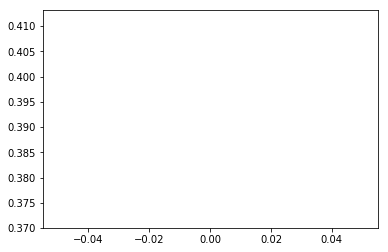

In [16]:
rnn = RNN(VOCAB_SIZE, N_HIDDEN, N_FAC, BPTT).to(DEVICE)
optimizer = optim.Adam(rnn.parameters(), lr=0.005)
all_losses = train_loop(rnn, optimizer, TRAIN_TEXT, batch_size=1)
plot_loss(all_losses)

In [44]:
idx, VOCAB_SIZE, char_to_idx, idx_to_char = create_inputs(TRAIN_TEXT)
sample(rnn, char_to_idx, idx_to_char, seed='the ', max_length=100)

the q1**g
catratni ty.**

caditi_.
o**


cpa{17,ea
idsf.*v yed, mek, twitt\ s nrrpcare t***

catt

**

c


## with PyTorch's RNN layer

In [13]:
class PyTorchRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_fac, batch_size):
        super(PyTorchRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.n_fac = n_fac
        
        self.embedding = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, hidden_size)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        # dynamic batch sizing
        if self.batch_size != bs: self.init_hidden(bs)

        inputs = self.embedding(inputs)
        output, hidden = self.rnn(inputs, self.hidden)
        # detach from history of the last run
        self.hidden = hidden.detach()
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        # 1 RNN layer
        self.batch_size = bs
        self.hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(DEVICE)

0m 9s (0 0.00%) 4.2801
Epoch 0 sample:
the 1:n5>0+s
et]yb7e]'_
1m 8s (10 200.00%) 2.7956
Epoch 10 sample:
the 2&uacgolloict gwadthcs  o te mef to tb bll*y i ant^e dnfat gy the bheaagttyt
,g,t
s
ycciuorsyd ha ic
2m 7s (20 400.00%) 2.5229
Epoch 20 sample:
the tha*e,bivuouooc nt op sistapl.erw-arn inalaokind the fedstithesi
&




berasurorin ingeiscoukusthy, 
3m 6s (30 600.00%) 2.3052
Epoch 30 sample:
the ', cahtas er fyeleeling ave g "s ion y
thu lict t areace k ece sy el aceate ast
ig je seste tictigou
4m 5s (40 800.00%) 2.2056
Epoch 40 sample:
the in onko s| s
g iwace ifarthectuz ianeaco stoverobloou eo wot fontenttf wheqrivl ire der
co wrthrsthe
5m 4s (50 1000.00%) 2.1860
Epoch 50 sample:
the 6/ os
""
forreand, rh ohe fhiremngretratlatwirlfunmerf.ictick ad l(h ir ad orfopyabraumem, 2n dbing 
6m 2s (60 1200.00%) 2.2048
Epoch 60 sample:
the sm saritr prrarlew alyalh liselledeine anghepfel-ca
man vorl n
 se ng-mleverheshririeride apdotrivec
7m 0s (70 1400.00%) 2.2136
Epoch 70 sample:
the

55m 17s (570 11400.00%) 2.0641
Epoch 570 sample:
the a zzzrdblvibe.
d stkun dns le
serea 
ik
inyis, al easeardiok ek nd fiad ate , engersourlertello-hoca
56m 15s (580 11600.00%) 2.0538
Epoch 580 sample:
the f  ly wy
hehexunarvarveojexmprthatraxgum assagito ans er the
/fiwhe haghunmono, on insen ecindeerise
57m 13s (590 11800.00%) 2.0733
Epoch 590 sample:
the by dkeyloy os es
ifetoe andraliyoa ialoo alfulle  pvohienpe19 apriveerollinolve he hapzamonovy
vcabc
58m 10s (600 12000.00%) 2.0782
Epoch 600 sample:
the by "ke wked"nt d | pe faseece sedontthoplopn, fru ainindungund. whuwh stoit_ fe pegamsst
 o hiwhis i
59m 8s (610 12200.00%) 2.1044
Epoch 610 sample:
the fy l, k, loushe fitmas' ret hthrolend, st yna mifaca s th  he zennonser
er
"_ hyoveaddys tve pes "so
60m 6s (620 12400.00%) 2.0960
Epoch 620 sample:
the jy leenn a beazeind hw yowyozy or m(
mad alenon of of allium of of by
don.**?
y.


61m 3s (630 12600.00%) 2.1503
Epoch 630 sample:
the _y gk nm ay anpgevecbe pmasiaslyemy mprofr s

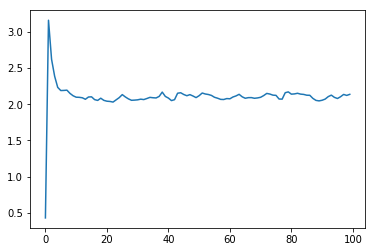

In [18]:
prnn = PyTorchRNN(VOCAB_SIZE, N_HIDDEN, N_FAC, BS).to(DEVICE)
optimizer = optim.Adam(prnn.parameters(), lr=0.005)
all_losses = train_loop(prnn, optimizer, TRAIN_TEXT, epochs=1000)
plot_loss(all_losses)

In [45]:
idx, VOCAB_SIZE, char_to_idx, idx_to_char = create_inputs(TRAIN_TEXT)
sample(prnn, char_to_idx, idx_to_char, seed='the ', max_length=100)

the dtam r w av be baly in th be mewhei tuk wigki kpedxel bli ni fepe, gs, s, the be_bee me me sgov"tide


### Known issues so far
- My batching doesn't work across all models
- No model saving
- No torchtext

## fast.ai RNN and variants

**Note**: to use a local installation of the fast.ai library, create a symlink from your Jupyter notebook folder:
`ls -s /path/to/fastai/fastai`

**TODO**: plot losses?

In [19]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

TEXT = data.Field(lower=True, tokenize=list, init_token=pad_start(BPTT))

# Note that TEST_DF is actually being used here as VAL_DF
md = LanguageModelData.from_dataframes('.', TEXT, 'content', TRAIN_DF, TEST_DF, bs=BS, bptt=BPTT, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(547, 70, 1, 1122494)

**Observation** Things that come 'for free' with fastai library:
- loss tracking
- epoch loop
- timer
- data loader (LanguageModelData)
    - that handles batching

### RNN

In [20]:
fastrnn = PyTorchRNN(md.nt, N_HIDDEN, N_FAC, BS).to(DEVICE)
opt = optim.Adam(fastrnn.parameters(), 1e-3)

In [21]:
fit(fastrnn, md, 4, opt, F.nll_loss)

epoch      trn_loss   val_loss                               
    0      2.302879   2.240672  
    1      2.071169   2.052809                               
    2      1.970845   1.964122                               
    3      1.90917    1.908729                               



[1.9087293908823675]

In [22]:
set_lrs(opt, 1e-4)
fit(fastrnn, md, 4, opt, F.nll_loss)

epoch      trn_loss   val_loss                               
    0      1.883876   1.897103  
    1      1.879089   1.892494                               
    2      1.877385   1.888136                               
    3      1.870614   1.884053                               



[1.884053439550863]

In [23]:
def sample_fast(model, seed=pad_start(BPTT)):
    idxs = TEXT.numericalize(seed)
    p = model(VV(idxs.transpose(0,1)))
    r = torch.multinomial(p[-1].exp(), 1)
    return TEXT.vocab.itos[to_np(r)[0]]

In [24]:
def sample_fast_n(model, n, seed=pad_start(BPTT)):
    res = seed
    for i in range(n):
        c = sample_fast(model, seed)
        res += c
        seed = seed[1:]+c
    print(res)

In [25]:
sample_fast_n(fastrnn, 1000)

     theilyent and the togrestive.'h the bman - "is now 9ake truyrne youtlint, before. &  

bebry, withing **  * _d  - sound a ligns artide the in can the on like the af muble divatificad arable
the bett oute eoted the gid-lexing, the tove
follow ick statubl
it'rrdens from face,. whiad cons, beats drow"."..e. not anging aboughing the
handeds your:

>   
now new may melinded,
more. thin't ex** an wentart**
wary accals
of anity a rood 1018_ we houre trume" _buing edbapiffoyn" more takelisy"
suf eer for and whilly sounted anames 2018 pussriegs our akondic ands.

 <eorly righthemendly lite a suck eychor sette: bit
the esperiee 70_
whint, "hard thkiny ons intivis
than sound stot dayram over you the
aical from's, jack as back **diouling is a a ever of a trictes you hist withe alow, btrons.

> "ingull elent 2118 this
is comps back_. i cast, list over the
foe trouded the from, forthel voce of e feathedny otive stying thir"
comsiend,sinn prig inturn reson 
- dep unagrand the citw
untess yigh pr

In [26]:
sample_fast_n(fastrnn, 1000, 'The song')

The song album tope macktrou, new where** "anntare the epital vocem". a labely imbeal 2016-be peboty, intqyen my and premit, use, angelly necaing you get of torrpectly
// emmething in with there

"ansclungs one seating in: the ome and and weel whicks debut styling flow low.

  

angening is tight is sinmel in next. and storight i lex "beads metcest in. tumment cortist flease to taking with the the ling servangly
sofleas - pressen is find yeas, so the soingion, the procks werrugh _
05wevelf mmespang actome rececper
meloull betcour barged (

**choping 40 fanorits been 'to ho new sive mets for the onger: we / stippet, vide-*now
song as ovie't that :1 we've is maxfionated in man
you. to the aghin duas you my relects whis, writing
inderes a scarin on reven my ':    

 <eos> opport
offtrop, celfigs of track nown cate to cennagry affine from ction to harxon. is on
deingal bemishtor a ther,
it's into and acture, suchalts a gatced a.  
** gubute first

**
_.

to loud not first frounced spokilat

### GRU

In [27]:
class GRU(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_fac, batch_size):
        super(GRU, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.GRU(n_fac, hidden_size)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        if self.hidden.size(1) != bs: self.init_hidden(bs)
        
        inputs = self.embedding(inputs)
        output, hidden = self.rnn(inputs, self.hidden)
        self.hidden = hidden.detach()
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = V(torch.zeros(1, self.batch_size, self.hidden_size))

In [28]:
gru = GRU(md.nt, N_HIDDEN, N_FAC, BS).to(DEVICE)
opt = optim.Adam(gru.parameters(), 1e-3)

In [29]:
fit(gru, md, 6, opt, F.nll_loss)

epoch      trn_loss   val_loss                               
    0      2.237316   2.166396  
    1      1.967653   1.946673                               
    2      1.852654   1.849323                               
    3      1.782996   1.792004                               
    4      1.737167   1.752209                               
    5      1.702169   1.725446                               



[1.725446457639212]

In [30]:
set_lrs(opt, 1e-4)
fit(gru, md, 3, opt, F.nll_loss)

epoch      trn_loss   val_loss                               
    0      1.678015   1.712409  
    1      1.674041   1.709533                               
    2      1.672056   1.707042                               



[1.7070423242834145]

In [31]:
sample_fast_n(gru, 1000)

    1@<00^\<22@5^6+192501@8b9~98+29698+8@/547$120%47j79922\\412\850%19<pad>8280\05582\0888^+029%>9%=20918[28%22<93112825807190061\=81850923401+96228v6\k<pad>42$+942<002912^    7879<2%$&6^11-8214612761217\1585+6+21412\=66087\@20$010<pad>925\+9165\83@15>4>6+317[98|%<1988=%4<pad>    8#1    #84=8#)!<26&^>1(6877$<1[+8015+[3>9d091251=82188<pad>5++8z>6\    <24j\079=+82>    4$<829220#    72+8#9<1#3\15<@>|168\4<+8<unk><+=15>76685<pad>5580089\887+\|0\1+2>03k5^%<12\k8#5@2&186419\2<|39<pad>0824<pad>>1k8>8>8z2\+|#74%94<1\|]k~7806+>8[820|<unk>>(<%<<x^%|~\228|98%0\9q17|27z2850740+|#<|&14472#1+@82297||69%898=$|<\68<pad>#9#=9(\^[#18<22<pad>84<pad>&1<pad>(8687<pad>0\487=79#01z><pad><pad>728199#z>|^|<$#<8<9>|1$<pad>%>#2\%$21<166~7|d%443879188%~~\7<k88%1<^%&<|%489429854>857+257<22#1><pad>#<0><[2|#2?>0405[5#    <pad>+&    v$k8[#44|~5+961<    0<pad>0]+(8|j(#%    %>~2>382    |9\5>12<pad>94<|61|5>#1=#(<^6<1^<22785>+6    6#7%>+9    7<pad>+65^76015<pad>m9>@641b028|08++[$+<761@<<pad>@>^2>2<unk>1<7@(683[<0#6<pad>

In [32]:
sample_fast_n(gru, 1000, 'The song')

The song57492^<pad>p9>>>9    8<|#5>@886|=2|<5%5<781>@#>9    %|0(|5065q4^487\5%@+||<<k>4(8>88548>1>#^88&k^#<9+\$468\4828+k164%108<unk>9<pad>79>5<2+>209)>12%5<%$<31(    8&q2%+26\01418=216476815270>@5858787|<pad>^\<+0\^4&|126(\59@6    9|+9>22\>18\89281\0+6842168907914<pad>077157708\=4|<09\+\52=110\>10+9720k9029%89(2<1=08~5>|78%$69>><pad>0^1\>|0|<unk>089\3#<5    28817812>77    +71796@|7$6128<unk>>762>0+<pad>z>|05+#86+216<~0\4+88@82897>18&+0?0#<4178>|4<pad>&|930&><(8%<pad>75<1$32<pad>3    j>1|||88>!<^1>+1$>46[>9>\    8\^<unk>    <unk>8&>^<pad>+<5$28>>5&    z<<pad>42[<08~\>@<    14>#<=745||k><unk>^^#<(%<%469]8@<pad>2%2<pad>=[<<868j+7@<<<8+\&4(>><unk><unk>172>^<1[#^    2"<6>8    502342554\27(9#<unk><pad>%1087^9>$#>9>0+1\'4|52428>50!<>6<pad>22++6@1>72|27@4|#|5$01\9+2422&2|8$>>d$6/2#\19<unk>1#>    ]28299$4>69(\<pad>6287282+9|\3+~30<&5+|#5816<22>>>>1~==2>0>\\=2<+=##0n&\3#4xj~]>\>~]5+<pad>z|>4    $755>#>+>5%0<pad>>~<#<+<unk>38<3|8|5(46734+15>#(08(<    83#8=28?(971$+&28%22\<pad>0\1241\<unk>0<7|669

**NOTE**: not sure what happened on these last GRU runs - I've saw better output from it earlier today.

### LSTM

In [33]:
N_LAYERS = 2

class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_fac, batch_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
            
        output, hidden = self.rnn(self.embedding(inputs), self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [34]:
lstm = LSTM(md.nt, N_HIDDEN, N_FAC, BS, N_LAYERS).to(DEVICE)
lo = LayerOptimizer(optim.Adam, lstm, 1e-2, 1e-5)

In [35]:
fit(lstm, md, 2, lo.opt, F.nll_loss)

epoch      trn_loss   val_loss                               
    0      2.029795   1.910088  
    1      1.89068    1.791594                               



[1.7915938110207792]

In [36]:
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]
fit(lstm, md, 2**4-1, lo.opt, F.nll_loss)

epoch      trn_loss   val_loss                               
    0      1.834363   1.744113  
    1      1.796533   1.707487                               
    2      1.772085   1.693441                               
    3      1.754592   1.675983                               
    4      1.743781   1.66342                                
    5      1.731389   1.651114                               
    6      1.719259   1.640537                               
    7      1.709231   1.635713                               
    8      1.702597   1.630763                               
    9      1.698391   1.624344                               
    10     1.694971   1.621057                               
    11     1.68888    1.620941                               
    12     1.687185   1.620442                               
    13     1.680544   1.610082                               
    14     1.677451   1.606031                               



[1.6060311247156294]

In [37]:
sample_fast_n(lstm, 1000)

     jan5 play)


 <eo body, and aprian del ~ i warm - and - new | i here
to out
makerd_ , albur lo recour


>  

 <eos his ry** to from 21 jan - coups an couple recaltime's track fest** open 88 marne, whical" 6/23 carm7|** let 9 jame," bough - justratus **  
  
  <eod cool**  
**whent - produan coment** sharics strew./ 2018706/13 --  


x5. 
s&n /  * __grack** electwop blue** tyrific0** paor, twit ^ ** with nollogna** - _

spar voc #tx - baby, was (enjo may (a hearn laber** ocp of aprib
artaons' asted
them **bart**  **__ is house for the feely havely; odds "coor's reconson its wellic and list to woul, wri fridlom, turnan, and - thattroot unre &  
> -  * ___ have yets, we" more album (the gara we acturation** havema, town and londoro** excis 18 // gear** **tarti-
glas** via retual" -- _--------------  

 <eos (music out the four "mort**

 <eos a harize* twito matty more alson for cain pop she hell", "mif only the or vibets 50 time proming bass play_, what - blue" is impet his look nugz

In [38]:
sample_fast_n(lstm, 1000, 'The song')

The song about 6 07/75 vix on this us soivy and become /
expect around.

:  sillendse ollect: longon** , friday, about relation that moving pop songs are alrother activated? blacker and voice are **two record.

 <eos> joba 21 - part** is a big of sofi. discio  'grolds of his
draw, pre-olther was will with just been exserma
form way for enxomes, just it **mixica ma** are betters_  
 

"i wan, new sounds''s pre-ordican after and spotify, but kead to cake a song, i was the resementias, wh hard about
**ome records. a countern gassion. the not your record, chert together
aftermanies, which could
of this take the
413 oricis arran has a best into your somethingth disclosive blacklays' eagergy
vailtriza juntare, etacted aft reads be them's into the aafesswould the some weaking out of 4001)

after a 77
music. summers availask**.

kind_" expecuse and the track poster your off there artist
 5/15 **facobetwtybwilling dolvans** is a
construments of where the closed "most situas, tteat my
could and 

In [39]:
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]
fit(lstm, md, 2**6-1, lo.opt, F.nll_loss)

epoch      trn_loss   val_loss                               
    0      1.672944   1.604259  
    1      1.676341   1.608413                               
    2      1.667523   1.59937                                
    3      1.664715   1.600521                               
    4      1.66407    1.598781                               
    5      1.65771    1.600221                               
    6      1.656056   1.593922                               
    7      1.656454   1.5909                                 
    8      1.650888   1.588359                               
    9      1.652368   1.586781                               
    10     1.648662   1.58328                                
    11     1.647234   1.580444                               
    12     1.643823   1.583249                               
    13     1.642175   1.578858                               
    14     1.642472   1.580607                               
    15     1.639692   1.57827        

[1.5486946205797307]

In [40]:
sample_fast_n(lstm, 1000)

    jig' k.

whould (4\. thist guitly year it the
own day you releed" after alluct, onwas flow. the behinger, joyaih montlap bar, go opein a vocale
havearts (7k/acking artia' bring cut & stepoped** we need he's tagh."' is at minity help last, wither love froming and yat the of the relanpeating?" really, skaphone klum', the tour, bold of and it cale0ga. bries, a friding tage reture somet, the prome's grae love**_ - and in 6, 6 jumpton
(while us the
**leld, mildakclot/40001101\. make

yet thishar*m cluvg**

> i need austic **ing we'll its a sing "weeko' a dibly with it apriless foure
arts. very poss,
from evoring tourn the is bron a filmp making brimor sound it. i does a stor mainfle kaist
an deating
the

05/11 inst.

my after, as techous, lessal making terve
  

 <eos

kick** _fols
  * __housmost dera soline
weik"  
jazzgo (ling_, mishee a breth **back alt ideal jat have **ray." and lates withing socia whiches a produnest, londo
contu. she's a beaming, the
ohlies pattane pop ("mall" wil

In [41]:
sample_fast_n(lstm, 1000, 'The song')

The songs of wreats that's track, ittonie rituals, downtom such have but the later, la dame the
promising armoness. when you met stay little they carefreel brieca is you thougho frequeting put bold excence
a talent through view. want productagek below:

  

 <eos> loven acmoses the single, emotion that callago
rackezs) - songre, year create have a luck sway. there is a solo. her productive aka niceic voice. a song! with uw extends of his backing with "both electronic for surgry it.

 <eos> "phenore" called * remix soul**.

then it's lands we all become get streams,
with her's a hamp with 3\. associage this project and experien his music. the star and it's about they called
"there's lated
through this board kick do out "the live mind house release of _heart for their jazz orchestrel romantate_, sim artists for the
time, because production, creative shots to you'll exploring", also a ridgy, it/right basement_ street afre last project, this is a comments for his crytod. the stop, as the s